In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
%pylab inline

from torch import nn, optim

from tqdm import tqdm
import jax
import jax.numpy as jnp
import numpy as np
# import tensorflow_probability as tfp; tfp = tfp.substrates.jax
# tfd = tfp.distributions
# tfb = tfp.bijectors

import torch
import jaxlie
from gecco_torch.utils.isotropic_gaussian import IsotropicGaussianSO3
from gecco_torch.utils.isotropic_plotting import visualize_so3_probabilities
from gecco_torch.scene.gaussian_model import GaussianModel

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample', 'step', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Load rotation distribution

In [93]:
gc = GaussianModel(3)
gc.load_ply("/globalwork/giese/gaussians/02691156/1a04e3eab45ca15dd86060f189eb133/point_cloud/iteration_10000/point_cloud.ply")
rotations_plane = gc.get_rotation.detach() # quats in wxyz
# speichere sie für so3diffusion models
np.save("/home/giese/Documents/SO3DiffusionModels/rotations_plane.npy", rotations_plane.cpu().numpy())
# bringe sie in xyzw, weil das ist womit lietorch später arbeitet
rotations_plane = rotations_plane[:,[1,2,3,0]]


## visualize plane rotation distribution

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


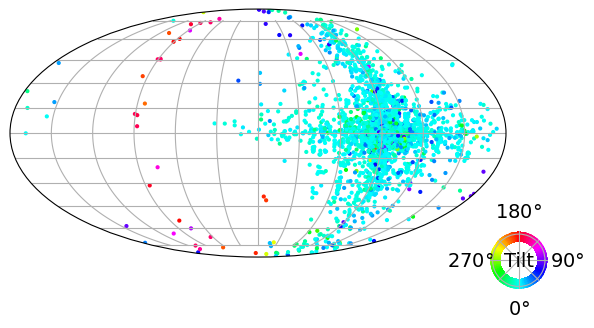

In [94]:
# Create a checkerboard grid
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in rotations_plane]),
    0.001);

## Visualize car rotation

In [95]:
gc = GaussianModel(3)
gc.load_ply("/globalwork/giese/gaussians/02958343/19c25429d34ce9748c844a5e3a5e1a93/point_cloud/iteration_10000/point_cloud.ply")
rotations_car = gc.get_rotation.detach() # quats in wxyz
# bringe sie in xyzw, weil das ist womit lietorch später arbeitet
rotations_car = rotations_car[:,[1,2,3,0]]

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


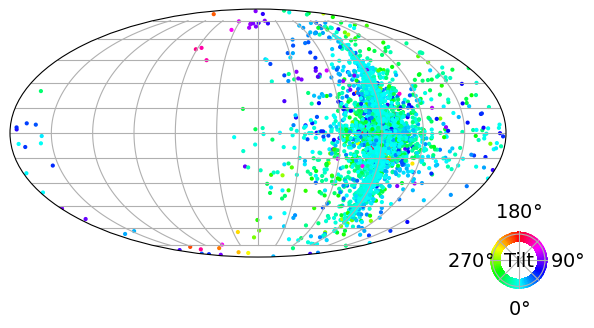

In [96]:
# Create a checkerboard grid
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in rotations_car]),
    0.001);

## Create the noisy dataset

In [97]:
# This will decide our noise schedule, to start with, here I use a linear noise schedule in 
# variance, based on the Variance Exploding SDE (note, slightly diffrent from the choices of Ho et al.)
# This is not necessarily the best choice, this is just for testing
delta = 0.01 # delta in noise variance
noise_schedule = jnp.arange(0.01,0.9, delta) # Noise variance

In [98]:
def sample(R, scale):
    # print(f"rotations x shape {rots.shape}")
    # x = lietorch.SO3.InitFromVec(rots)
    # print(x)
    # print(f"scale shape {scale.val.shape}")
    # Sampling from current temperature
    dist = IsotropicGaussianSO3(R, scale)
    qn = dist.sample()

    # zurück zur wxyz darstellung
    # qn_wxyz = qn[:,[3,0,1,2]]

    
    # Sampling from next temperature step 
    scale_torch = torch.sqrt(delta * torch.ones(R.shape[0],device=qn.device))
    dist2 = IsotropicGaussianSO3(qn, scale_torch)
    qnplus1 = dist2.sample()

    # zurück zur wxyz darstellung
    # qnplus1_wxyz = qnplus1[:,[3,0,1,2]]
    
    # zurück zur wxyz darstellung
    # x_wxyz = x.vec()[:,[3,0,1,2]]

    res = {'x': R, 'yn': qn, 'yn+1': qnplus1,
            'sn':scale, 'sn+1':torch.sqrt(scale**2 + delta)}
    return res

def get_batch(seed, batch_size=512):
    key1, key2, key3 = jax.random.split(seed,3)
    # Sample from the target distribution
    perm = torch.randperm(rotations_plane.size(0))
    idx = perm[:batch_size]
    Rs = rotations_plane[idx]
    
    # Sample random noise levels from the schedule
    s = jax.random.choice(key3, noise_schedule, shape=[batch_size])
    s = torch.from_numpy(np.array(s)).sqrt()
    
    # Sample random rotations
    samp = sample(Rs, s)
    # samp['yn'] = samp['yn'][-1]
    # samp['yn+1'] = samp['yn+1'][-1]
    # samp['x'] = samp['x'][-1]
    return samp

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


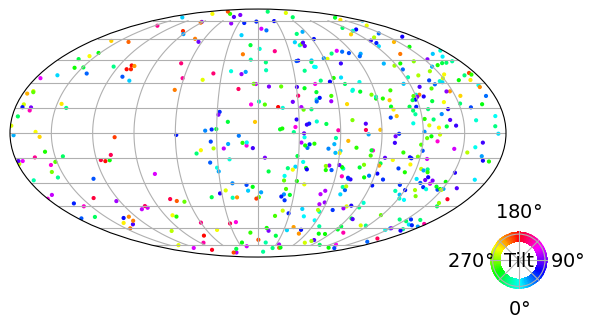

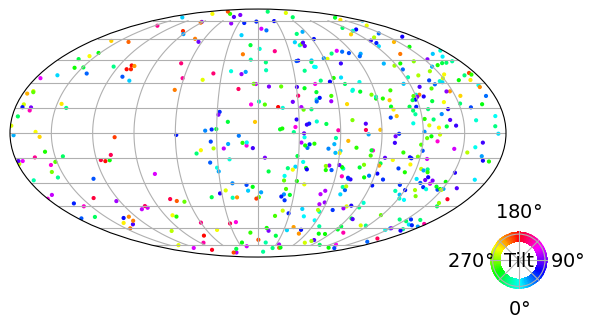

In [99]:
batch = get_batch(jax.random.PRNGKey(0))
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in batch['yn']]),
    0.001
    )

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


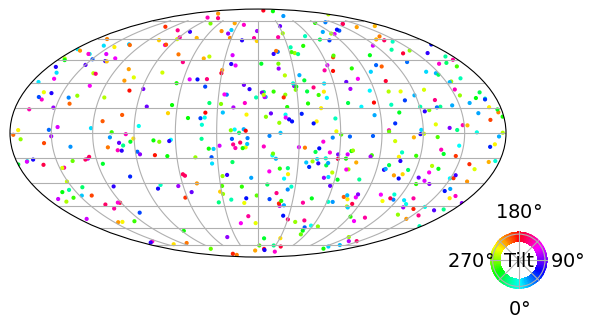

In [100]:
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in batch['yn+1']]),
    0.001);

## Train a Denoising Diffusion Model without Analytical Solution

In [101]:

class SimpleMLP(nn.Module):
    def __init__(self,input_size=5):
        super(SimpleMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
        )
        self.layer_mu = nn.Linear(256, 4)
        self.layer_scale = nn.Linear(256, 1)

    def forward(self, x, s):
        concat = torch.cat([x, s], dim=-1)
        out = self.mlp(concat)
        mu = self.layer_mu(out) + x
        mu = mu / torch.norm(mu, dim=-1, keepdim=True)

        scale = self.layer_scale(out)
        scale = nn.functional.softplus(scale) + 0.001
        return mu, scale

In [102]:
import haiku as hk

# Create a random sequence
model = SimpleMLP().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
rng_seq = hk.PRNGSequence(42)
losses = []


In [103]:
def train(model, batch):
    model.train()
    optimizer.zero_grad()
    # yn1 = torch.from_numpy(np.array(batch['yn+1']))
    # sn1 = torch.from_numpy(np.array(batch['sn+1']))
    yn1 = batch['yn+1'].cuda()
    sn1 = batch['sn+1'].cuda()

    mu, scale = model(yn1, sn1.reshape(-1,1))

    def fn(x, mu, scale):

        # von der wxyz zur lietorch xyzw darstellung
        # mu = mu[:,[1,2,3,0]]
        dist = IsotropicGaussianSO3(mu, scale, 
                                    force_small_scale=True)

        # logprob auch in der lietorch xyzw darstellung
        # prob_dist = dist.log_prob(x[:,[1,2,3,0]]) 
        prob_dist = dist.log_prob(x) 
        return prob_dist # shape 512
    
    yn = batch['yn']
    loss = (-fn(yn, mu, scale)).mean()
    loss.backward()
    optimizer.step()
    return loss.item()

In [104]:
for step in tqdm(range(1000)):
    batch = get_batch(seed=next(rng_seq))
    loss = train(model, batch)
    if step % 50 == 0:
        print(loss)
    losses.append(loss)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
  2%|▏         | 17/1000 [00:00<00:12, 81.46it/s]

-2.548511266708374


  6%|▌         | 62/1000 [00:00<00:11, 82.45it/s]

-2.9677116870880127


 12%|█▏        | 116/1000 [00:01<00:10, 82.44it/s]

-3.3883304595947266


 16%|█▌        | 160/1000 [00:01<00:10, 80.35it/s]

-3.7941789627075195


 21%|██▏       | 213/1000 [00:02<00:09, 80.21it/s]

-5.495587348937988


 27%|██▋       | 267/1000 [00:03<00:08, 82.00it/s]

-6.842872142791748


 31%|███       | 312/1000 [00:03<00:08, 81.84it/s]

-6.811803817749023


 37%|███▋      | 366/1000 [00:04<00:07, 82.14it/s]

-7.126556873321533


 41%|████      | 411/1000 [00:05<00:07, 82.18it/s]

-6.663553237915039


 46%|████▋     | 465/1000 [00:05<00:06, 82.04it/s]

-7.188204765319824


 51%|█████     | 510/1000 [00:06<00:05, 82.00it/s]

-6.220825672149658


 56%|█████▋    | 564/1000 [00:06<00:05, 82.16it/s]

-6.218125343322754


 61%|██████    | 609/1000 [00:07<00:04, 82.09it/s]

-7.2587738037109375


 66%|██████▋   | 663/1000 [00:08<00:04, 81.36it/s]

3.6629276275634766


 72%|███████▏  | 717/1000 [00:08<00:03, 81.96it/s]

-7.223476886749268


 76%|███████▌  | 762/1000 [00:09<00:02, 82.01it/s]

-2.1348118782043457


 82%|████████▏ | 816/1000 [00:09<00:02, 82.11it/s]

-7.108343124389648


 86%|████████▌ | 861/1000 [00:10<00:01, 82.04it/s]

-7.186740875244141


 92%|█████████▏| 915/1000 [00:11<00:01, 82.40it/s]

-6.831812858581543


 96%|█████████▌| 960/1000 [00:11<00:00, 82.19it/s]

-7.402194976806641


100%|██████████| 1000/1000 [00:12<00:00, 81.72it/s]


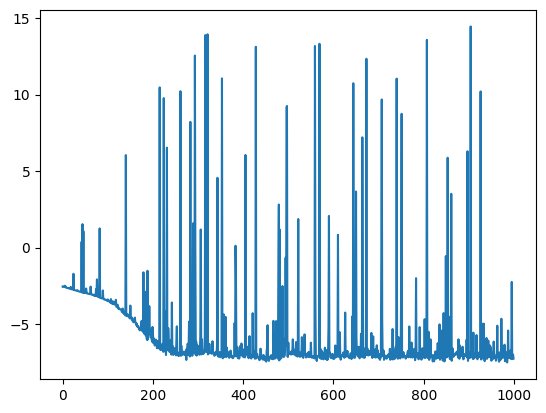

In [105]:
plot(losses)

## Sampling from the model

Note that here, this is only a small test, starting from a noised version of the target distribution, not uniform noise

In [106]:
# Try to sample with the trained model
points = rotations_plane
nsamps = points.shape[0]
points = sample(rotations_plane, torch.from_numpy(np.array(noise_schedule[-1])).sqrt()*torch.ones(nsamps))

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


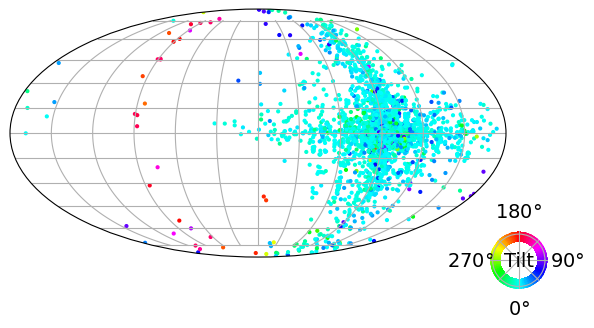

In [107]:
# Target distribution -> Die die wir lernen wollen
import matplotlib.pyplot as plt
p = visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in points['x']]), 
    0.001);
p.savefig('target.png')

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


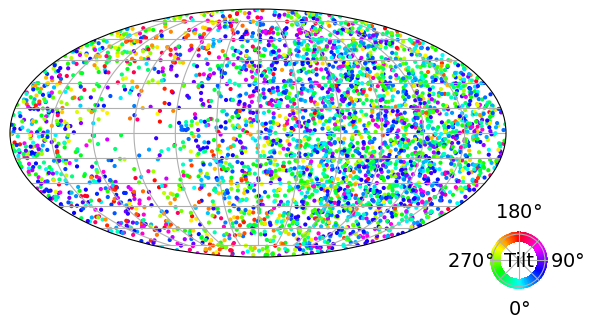

In [108]:
# Samples at T=~1 # Nur noise
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(x[[3,0,1,2]].cpu().numpy()).as_matrix() for x in points['yn']]),
    0.001);

In [115]:
def fn_sample(mu,s):
    ig = IsotropicGaussianSO3(mu, s, force_small_scale=True)
    samp = ig.sample()
    return samp

# Running the denoising loop
x = points['yn']
reverse_noise_schedule = torch.from_numpy(np.array(noise_schedule[::-1])).cuda()
with torch.no_grad():
    for i,variance in tqdm(enumerate(reverse_noise_schedule)):
        var = variance.sqrt() * torch.ones((nsamps,1),device=x.device)
        mu, s = model(x, var)
        # print(f"{i}, mu shape {mu.shape}, s shape {s.shape}, {mu[0]}")
        x = fn_sample(mu, s)

129it [00:00, 184.73it/s]


tensor([-0.2313,  0.9281, -0.1360, -0.2582], device='cuda:0')

In [116]:
from gecco_torch.utils.isotropic_plotting import visualize_so3_density

/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


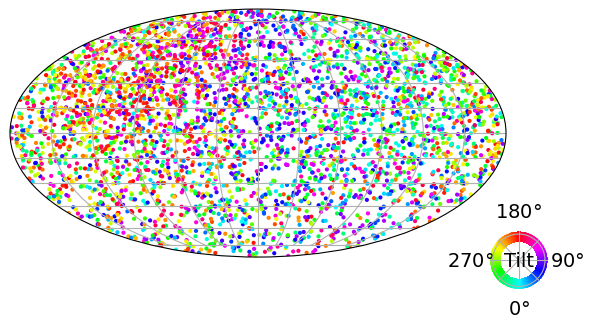

In [111]:
visualize_so3_probabilities(
    jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in x]),
    0.001);

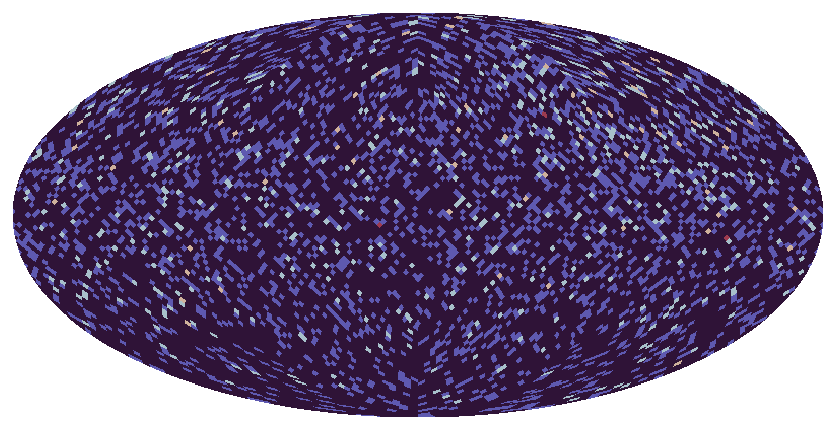

In [112]:
visualize_so3_density(
    jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in x]),
    32);